In [0]:
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO 
from PIL import Image
from collections import Counter


def ImageToData(filename,flip_up_side_down=True,
                    x_range=None,y_range=None,white_backscreen=False):
    """
    ペイントなどで作った画像から、
    データの作成を行う。
    具体的には、黒いドットを書き込むと、
    その座標を(x,y)とするデータを作成する。
    
    
    
    
    parameters
    ----------------------------
    filename: str
     画像のファイル名
        
    flip_up_size_down: bool
     上下の数値を反転させることで、matplotlibで描画するときに想定した形になる
     デフォルトはTrue
    
    x_range,y_range :list[min,max]
     デフォルトでは画像のサイズに基づいてデータが作成されるが、
     範囲を指定することで軸を変換する
     
    white_backscreen: bool
     白(255,255,255)を背景として、データと認識しない。デフォルトはFalse
    
    """
    
    with open(filename, 'rb') as f:
        binary = f.read()

    img = Image.open(BytesIO(binary))

    img_np = np.array(img)

    image_height,image_width,_ = img_np.shape

    #0-255の色配列をstr化 [0,0,0] -> "000-000-000"
    img_str_list=["{:03}-{:03}-{:03}".format(i[0],i[1],i[2]) for i in img_np.reshape(-1,3)]
    img_np_str=np.array(img_str_list).reshape(image_height,image_width)

    #色の出現頻度をcollections.Counterで作成
    color_counter=Counter(img_str_list)
    print(color_counter)
    
    #最も多く出現する色を背景色として認識する（most_common_color）
    if white_backscreen:
        most_common_color="255-255-255"
    else:
        most_common_color=color_counter.most_common(1)[0][0]

    #色辞書の作成 高い頻度を持つ色から0,1,2...となる（0は背景色）
    color_dict={key:i for i,(key,value) in enumerate(color_counter.items())}

    def transform_by_range(range_list,max_range):

        def inner(x):
            range_min=range_list[0]
            range_max=range_list[1]
            return (x/max_range) * (range_max - range_min ) + range_min

        return inner
    
    x_transform= (lambda x:x) if x_range==None else transform_by_range(x_range,image_width) 
    y_transform= (lambda y:y) if y_range==None else transform_by_range(y_range,image_height)

    data_array=np.empty((0,3))

    #画像内で、最頻色以外の色を、x,yの値と、色(出現頻度の多い順に1,2...)のデータに変換
    for row in range(image_height):

        for col in range(image_width):

            color_value=img_np_str[row][col]

            if not color_value==most_common_color:
                
                #np.arrayはすべて同じ形式にさせられる
                #どれかがstrだとすべてstrにされる
                 
                x_temp = x_transform(col)
                
                if flip_up_side_down:
                    y_temp = y_transform(image_height-row)
                else:
                    y_temp = y_transform(row)
                
                data_array = np.concatenate(
                    [data_array,np.array(
                        [[x_temp,
                        y_temp,
                        color_dict[color_value]]])],
                        axis=0)
    
    plt.figure(figsize=(5,5))   
    plt.scatter(data_array[:,0],data_array[:,1],c=data_array[:,2],s=5)
    
    if x_range: plt.xlim(x_range[0],x_range[1])
    if y_range: plt.ylim(y_range[0],y_range[1])
    
    return data_array

Counter({'255-255-255': 27981, '237-028-036': 189, '000-000-000': 130})


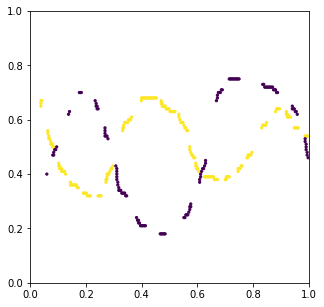

In [0]:
data = ImageToData("a_2.png",x_range=[0,1],y_range=[0,1])

Counter({'255-255-255': 156214, '000-000-000': 12270, '237-028-036': 10456})


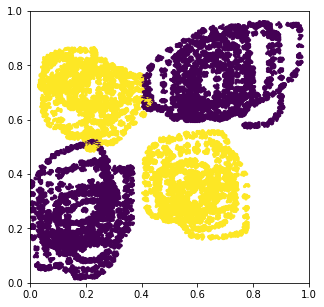

In [0]:
data = ImageToData("a_3.png",x_range=[0,1],y_range=[0,1])

In [0]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.preprocessing import PolynomialFeatures

X_data=data[:,0:2]
y_data=data[:,2]

svm_clf = Pipeline((
        ("poly_features",PolynomialFeatures(degree=3)),
        ("scaler",StandardScaler()),
        ("linear_svc",LinearSVC(C=1,loss="hinge"))))

svm_clf.fit(X_data,y_data)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

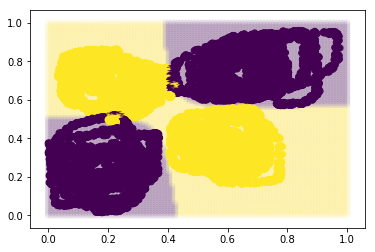

In [0]:
vx = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

svm_pred = svm_clf.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=svm_pred,alpha=0.05)
plt.scatter(data[:,0],data[:,1],c=data[:,2])

PolynomialFeatureの威力がわかった気がする


Counter({'255-255-255': 230446, '255-242-000': 12517, '000-000-000': 9159, '237-028-036': 8068})


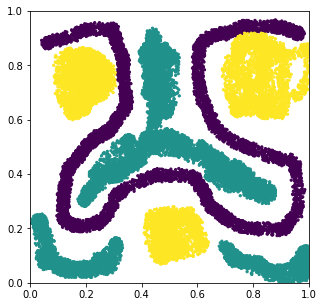

In [0]:
data4 = ImageToData("a_4.png",x_range=[0,1],y_range=[0,1])

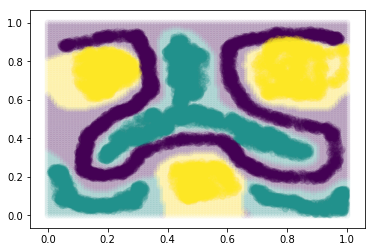

In [0]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC

from sklearn.preprocessing import PolynomialFeatures

X_data=data4[:,0:2]
y_data=data4[:,2]

svm_clf = Pipeline((
        ("poly_features",PolynomialFeatures(degree=3)),
        ("scaler",StandardScaler()),
        ("linear_svc",SVC(C=10,gamma=5))))

svm_clf.fit(X_data,y_data)

svm_pred = svm_clf.predict(X)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

svm_pred = svm_clf.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=svm_pred,alpha=0.05)
plt.scatter(data4[:,0],data4[:,1],c=data4[:,2],alpha=0.1)

明らかに過学習だが、gamma=5,C=10の威力は大きいのがわかる

Counter({'255-255-255': 222220, '237-028-036': 20614, '000-000-000': 17356})


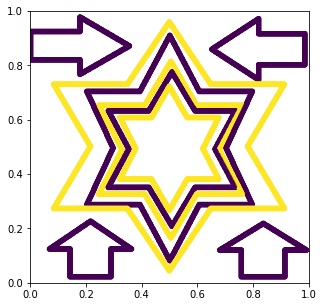

In [0]:
data5 = ImageToData("a_5.png",x_range=[0,1],y_range=[0,1])

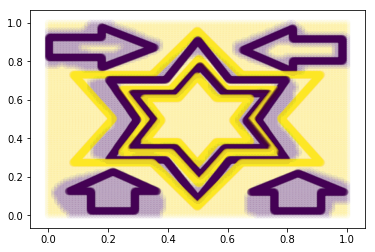

In [0]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC

from sklearn.preprocessing import PolynomialFeatures

X_data=data5[:,0:2]
y_data=data5[:,2]

svm_clf = Pipeline((
        ("poly_features",PolynomialFeatures(degree=3)),
        ("scaler",StandardScaler()),
        ("linear_svc",SVC(kernel="rbf",C=5,gamma=5))))

svm_clf.fit(X_data,y_data)

svm_pred = svm_clf.predict(X)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

svm_pred = svm_clf.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=svm_pred,alpha=0.05)
plt.scatter(data5[:,0],data5[:,1],c=data5[:,2],alpha=0.05)

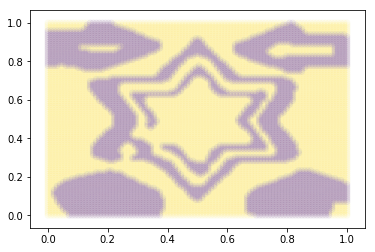

In [0]:
plt.scatter(X_test[:,0],X_test[:,1],c=svm_pred,alpha=0.05)

星の輪郭すら特徴をつかめているようだ。恐るべし。カーネルトリック

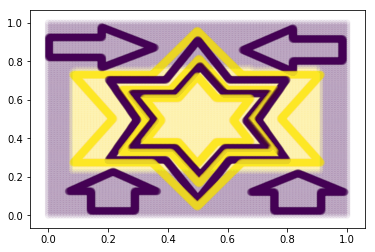

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20,criterion="entropy",
                            max_depth=3,max_features="auto",n_jobs=-1)

rfc.fit(X_data,y_data)

X_data=data5[:,0:2]
y_data=data5[:,2]

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

rfc_pred = rfc.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=rfc_pred,alpha=0.05)
plt.scatter(data5[:,0],data5[:,1],c=data5[:,2],alpha=0.05)


n_estimators=20,criterion="entropy",
                            max_depth=3,max_features="auto",n_jobs=-1

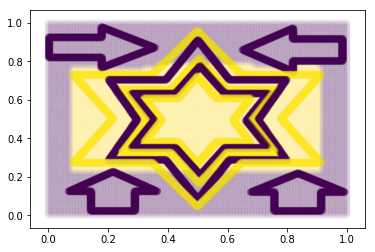

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,criterion="entropy",
                            max_depth=3,max_features="auto",n_jobs=-1)

rfc.fit(X_data,y_data)

X_data=data5[:,0:2]
y_data=data5[:,2]

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

rfc_pred = rfc.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=rfc_pred,alpha=0.05)
plt.scatter(data5[:,0],data5[:,1],c=data5[:,2],alpha=0.05)


Counter({'255-255-255': 253940, '000-000-000': 19364, '237-028-036': 18127})


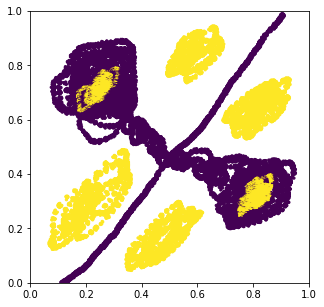

In [0]:
data7 = ImageToData("aaaaa.png",x_range=[0,1],y_range=[0,1])

In [0]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

X_data=data7[:,0:2]
y_data=data7[:,2]

y_categorical = to_categorical(y_data)[:,1:2]

model = Sequential()
model.add(Dense(128,input_dim = 2,activation="relu"))
model.add(Dropout(0.45))
model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

model.fit(X_data,y_categorical,epochs=20,batch_size=64)

model.evaluate(X_data,y_categorical,batch_size=64)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
37491/37491 [==============================] - 2s 63us/sample - loss: 0.6460 - acc: 0.6239
Epoch 2/20
37491/37491 [==============================] - 3s 70us/sample - loss: 0.5486 - acc: 0.7721
Epoch 3/20
37491/37491 [==============================] - 2s 64us/sample - loss: 0.4695 - acc: 0.7877
Epoch 4/20
37491/37491 [==============================] - 2s 61us/sample - loss: 0.3756 - acc: 0.8102
Epoch 5/20
37491/37491 [==============================] - 2s 60us/sample - loss: 0.3141 - acc: 0.8472
Epoch 6/20
37491/37491 [==============================] - 2s 60us/sample - loss: 0.2769 - acc: 0.8671
Epoch 7/20
37491/37491 [==============================] - 2s 61us/sample - loss: 0.2599 - acc: 0.8736
Epoch 8/20
37491/37491 [==============================] - 2s 60us/sample - loss: 0.2464 - acc: 0.8794
Epoch 9/20
37491/37491 [==============================] - 2s 59us/sample - loss: 0.2328 - 

[0.1299712780253411, 0.94702727]

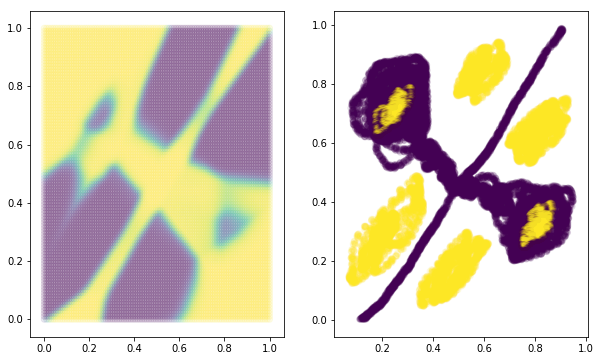

In [0]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

model_pred = model.predict(X_test)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].scatter(X_test[:,0],X_test[:,1],c=model_pred.reshape(-1),alpha=0.1)
axes[1].scatter(data7[:,0],data7[:,1],c=data7[:,2],alpha=0.1)

Counter({'255-255-000': 71133, '000-000-000': 31012, '255-000-000': 255})


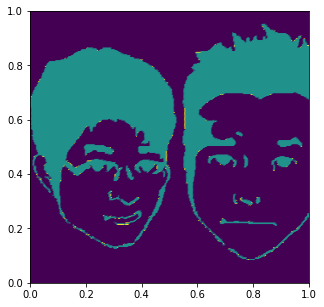

In [0]:
data8 = ImageToData("que-1042539910.png",x_range=[0,1],y_range=[0,1])

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

X_data=data8[:,0:2]
y_data=data8[:,2]

y_categorical = to_categorical(y_data)[:,1:2]



In [0]:
model = Sequential()
model.add(Dense(128,input_dim = 2,activation="relu"))
model.add(Dropout(0.45))
model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

model.fit(X_data,y_categorical,epochs=20,batch_size=64)

model.evaluate(X_data,y_categorical,batch_size=64)

Epoch 1/20
102400/102400 [==============================] - 7s 66us/sample - loss: 0.4060 - acc: 0.8141
Epoch 2/20
102400/102400 [==============================] - 7s 64us/sample - loss: 0.3244 - acc: 0.8589
Epoch 3/20
102400/102400 [==============================] - 6s 60us/sample - loss: 0.3061 - acc: 0.8678
Epoch 4/20
102400/102400 [==============================] - 6s 62us/sample - loss: 0.2946 - acc: 0.8760
Epoch 5/20
102400/102400 [==============================] - 7s 65us/sample - loss: 0.2843 - acc: 0.8824
Epoch 6/20
102400/102400 [==============================] - 7s 65us/sample - loss: 0.2754 - acc: 0.8884
Epoch 7/20
102400/102400 [==============================] - 6s 63us/sample - loss: 0.2694 - acc: 0.8912
Epoch 8/20
102400/102400 [==============================] - 6s 62us/sample - loss: 0.2630 - acc: 0.8934
Epoch 9/20
102400/102400 [==============================] - 6s 61us/sample - loss: 0.2580 - acc: 0.8948
Epoch 10/20
102400/102400 [==============================] - 6s 

[0.2135961019519494, 0.9140137]

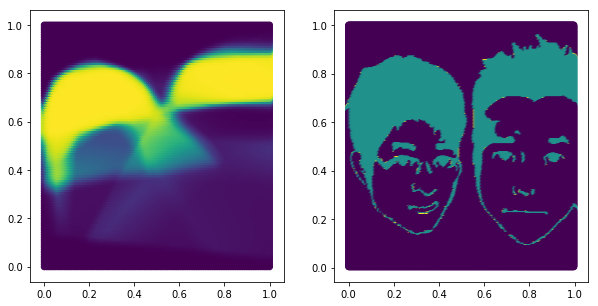

In [0]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)
X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]

model_pred = model.predict(X_test)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].scatter(X_test[:,0],X_test[:,1],c=model_pred.reshape(-1))
axes[1].scatter(data8[:,0],data8[:,1],c=data8[:,2])

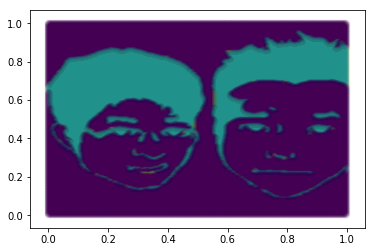

In [0]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC

from sklearn.preprocessing import PolynomialFeatures

X_data=data8[:,0:2]
y_data=data8[:,2]

svm_clf = Pipeline((
        ("poly_features",PolynomialFeatures(degree=3)),
        ("scaler",StandardScaler()),
        ("linear_svc",SVC(kernel="rbf",C=10,gamma=5))))

svm_clf.fit(X_data,y_data)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

np_mesh_x,np_mesh_y=np.meshgrid(x,y)

X_test = np.c_[np_mesh_x.ravel(), np_mesh_y.ravel()]
svm_pred = svm_clf.predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=svm_pred,alpha=0.05)
plt.scatter(data8[:,0],data8[:,1],c=data8[:,2],alpha=0.05)

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].scatter(X_test[:,0],X_test[:,1],c=svm_pred.reshape(-1))
axes[1].scatter(data8[:,0],data8[:,1],c=data8[:,2])
